In [174]:
import os
from tqdm import tqdm 

from dotenv import load_dotenv
load_dotenv()

from openai import OpenAI

import pandas as pd
import random

import ast

# Wikipedia API
import wikipedia as wp
from wikipedia.exceptions import DisambiguationError, PageError

# Plotting
import networkx as nx
import matplotlib.pyplot as plt

# Wiki Extractor

In [175]:
def paragraph2sentences(paragraph):
    sentences = paragraph.split('.')
    return sentences
class MyWikiPage:
    def __init__(self, query):
        self.page = wp.page(query)
        self.content = None
        self.paragraphs = None
        self.sentences = None
    def get_content(self):
        if self.content is None:
            self.content = self.page.content
        return self.content
    def get_paragraphs(self):
        if self.paragraphs is None:
            self.paragraphs = self.get_content().split('\n')
            self.paragraphs = [p for p in self.paragraphs if p != '' and len(p)>10 ]
        return self.paragraphs
    def get_sentences(self, paragraph_num = None):
        if self.sentences is None:
            self.sentences = [ paragraph2sentences(p) for p in self.get_paragraphs() ]
        if paragraph_num is None:
            return self.sentences
        return self.sentences[paragraph_num]

In [176]:
queries = ['plasma(physics)', 'Inductive Plasma', 'Capacitively Coupled Plasma', 'Inductively Coupled Plasma']
wiki_pages = [ MyWikiPage(q) for q in queries ]

In [177]:
paragraph = wiki_pages[0].get_paragraphs()[0]
paragraph

"Plasma (from Ancient Greek  πλάσμα (plásma) 'moldable substance') is one of four fundamental states of matter (the other three being solid, liquid, and gas) characterized by the presence of a significant portion of charged particles in any combination of ions or electrons. It is the most abundant form of ordinary matter in the universe, mostly in stars (including the Sun), but also dominating the rarefied intracluster medium and intergalactic medium."

In [178]:
sentences = wiki_pages[0].get_sentences(paragraph_num=0)
sentences[0]

"Plasma (from Ancient Greek  πλάσμα (plásma) 'moldable substance') is one of four fundamental states of matter (the other three being solid, liquid, and gas) characterized by the presence of a significant portion of charged particles in any combination of ions or electrons"

# Construct agent

In [179]:
# Replace with your OpenAI API key
openai = OpenAI(api_key=os.environ['OPEN_API_KEY'])

# Send a message to ChatGPT
system_message = '''Given a prompt delimited by triple backticks, perform the following actions:\n'''\
                 '''(1) identify as many relations among entities as possible\n'''\
                 '''(2) output is a list of ["ENTITY1","RELATION","ENTITY2"]\n'''\
                 '''    please use "" to wrap the entity and relation and don't forget to use [] for a triplet\n'''\
                 '''(3) use ,\\n to separate each relation\n'''\
                 '''(4) use , to separate each ENTITY and RELATION\n'''\
                 '''(5) If the given paragraph is not meaningful, please return CANNOT_BE_READABLE\n'''\
                 '''(6) please change all the character to lowercase\n'''\
                 '''(7) If the given sentence is not English, please translate to English\n'''\
                 '''The most important entity types are: person, organization, location, physical terminology, material, title, material, chemical reaction, and so on.\n'''\
                 '''Before extract the relations, please see the whole paragraph first and please merge the same semantics (including ENTITY and RELATION) as possible.\n'''\
                 '''Also check the true or false of the triple, if it is ambiguous or not scientific, please don't output that relation. \n'''

def get_relations_from_LLM( content ):
    completion = openai.chat.completions.create(
        model="gpt-4", # 'gpt-4', 'gpt-3.5-turbo'
        messages=[
              {"role": "system", "content": system_message},
              {"role": "user", "content": content}
        ]
    )
    return completion.choices[0].message.content

In [180]:
print(system_message)

Given a prompt delimited by triple backticks, perform the following actions:
(1) identify as many relations among entities as possible
(2) output is a list of ["ENTITY1","RELATION","ENTITY2"]
    please use "" to wrap the entity and relation and don't forget to use [] for a triplet
(3) use ,\n to separate each relation
(4) use , to separate each ENTITY and RELATION
(5) If the given paragraph is not meaningful, please return CANNOT_BE_READABLE
(6) please change all the character to lowercase
(7) If the given sentence is not English, please translate to English
The most important entity types are: person, organization, location, physical terminology, material, title, material, chemical reaction, and so on.
Before extract the relations, please see the whole paragraph first and please merge the same semantics (including ENTITY and RELATION) as possible.
Also check the true or false of the triple, if it is ambiguous or not scientific, please don't output that relation. 



# Extract Relation

In [181]:
def sentence2relation(sentence:str):
    sentences = sentence.split(',\n')
    relations = []
    for s in sentences:
        try:
            tmp = ast.literal_eval(s) 
            if len(tmp) == 3:
                relations.append( tmp )
        except:
            pass
    return relations

In [182]:
# single paragraph test 
paragraph = wiki_pages[0].get_paragraphs()[0] 
contents = get_relations_from_LLM(paragraph)
sentence2relation(contents)

[['plasma', 'is', 'one of four fundamental states of matter'],
 ['four fundamental states of matter', 'include', 'solid'],
 ['four fundamental states of matter', 'include', 'liquid'],
 ['four fundamental states of matter', 'include', 'gas'],
 ['four fundamental states of matter', 'include', 'plasma'],
 ['plasma',
  'characterized by',
  'presence of a significant portion of charged particles in any combination of ions or electrons'],
 ['plasma', 'is', 'the most abundant form of ordinary matter in the universe'],
 ['ordinary matter in the universe', 'mostly present in', 'stars'],
 ['stars', 'include', 'the sun'],
 ['ordinary matter in the universe',
  'dominates',
  'rarefied intracluster medium'],
 ['ordinary matter in the universe', 'dominates', 'intergalactic medium']]

In [183]:
# extract relation from wiki pages
relations_dict = {}
for ii, query in enumerate( queries[0:1] ):
    print(f'Now processing query - {query} ({ii+1}/{len(queries)}) ...')
    relation_query = []
    for paragraph in tqdm( wiki_pages[ii].get_paragraphs()[0:1] ):
        contents = get_relations_from_LLM( paragraph )
        relation_query += sentence2relation( contents )
    print(f'- relation number : {len(relation_query)}')
    relations_dict[query] = relation_query

Now processing query - plasma(physics) (1/4) ...


100%|██████████| 1/1 [00:07<00:00,  7.79s/it]

- relation number : 13


In [199]:
# add relation between page name and entities
new_relations_dict = {}
for query, relations in relations_dict.items():
    total_entities = set( [ relation[0] for relation in relations] + [ relation[2] for relation in relations ] )
    total_relations = set( [relation[1] for relation in relations] )
    print(f'{query} (query) has {len(total_entities)} entities, {len(total_relations)} relation, {len(relations)} total relation lines')
    new_relations = relations.copy() \
                    + [ [entity.lower(), 'is entity of', query.lower() ] for entity in total_entities ] \
                    + [ [query.lower(),  'has entity of',entity.lower()] for entity in total_entities ] 
    new_relations_dict[query] = new_relations

plasma(physics) (query) has 16 entities, 5 relation, 13 total relation lines


# Construct Graph

In [200]:
merged_relations = []
for query, relations in new_relations_dict.items():
     merged_relations += relations

total_entities_tmp = set( [ relation[0] for relation in merged_relations] + [ relation[2] for relation in merged_relations ] )
total_relations_tmp = set( [relation[1] for relation in merged_relations] )
print(f'Merged entity number   : {len(total_entities_tmp)}')
print(f'Merged relation number : {len(total_relations_tmp)}')
print(f'Merged relation lines  : {len(merged_relations)}')

Merged entity number   : 16
Merged relation number : 5
Merged relation lines  : 13


In [201]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for source, relationship, target in merged_relations:
    G.add_node(source)
    G.add_node(target)
    G.add_edge(source, target, label=relationship)

# Plot Graph

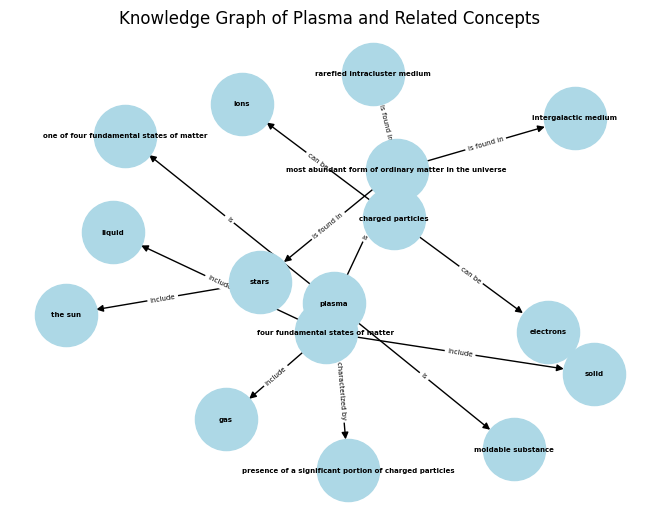

In [202]:
font_size = 5

# Define node positions in a circular layout
pos = nx.spring_layout(G, k=0.1, iterations=20)

# Draw the nodes
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=font_size, font_weight='bold')

# Draw the edge labels
edge_labels = nx.get_edge_attributes(G,'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=font_size)

plt.title("Knowledge Graph of Plasma and Related Concepts")
plt.axis('off') # Turn off the axis
plt.show()

In [188]:
# Correcting the mistake in adding the new edges with proper source, target, and relationship attributes
G_merged.add_edge("Capacitively Coupled Plasma", "Induction Plasma", relationship="is one kind of")
G_merged.add_edge("Inductively Coupled Plasma", "Induction Plasma", relationship="is one kind of")

# Since the graph structure is updated, let's use the kamada_kawai_layout for visualization
pos_merged_updated = nx.kamada_kawai_layout(G_merged)

# Drawing the updated graph with correct method
plt.figure(figsize=(20, 14))
nx.draw(G_merged, pos_merged_updated, with_labels=True, node_size=[node_sizes[node] for node in G_merged.nodes()], node_color=corrected_desaturated_blended_colors, font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_edge_labels(G_merged, pos_merged_updated, edge_labels={(u, v): d['relationship'] for u, v, d in G_merged.edges(data=True)}, font_color='darkblue')
plt.title("Updated Knowledge Graph with Hierarchical Relationships", size=20)
plt.axis('off')
plt.show()


NameError: name 'G_merged' is not defined

In [ ]:
# Correcting the use of an undefined variable 'specific_colors_updated' by defining a new specific colors mapping
# for the updated graph that includes "Plasma Physics" as a node.

# Define specific colors for the main plasma types and "Plasma Physics"
specific_colors_for_physics = {
    "Induction Plasma": "red",
    "Capacitively Coupled Plasma": "green",
    "Inductively Coupled Plasma": "blue",
    "Plasma Physics": "purple",  # Assigning a new color for the "Plasma Physics" node
}

# Apply the specific colors to nodes, defaulting to a neutral color for other nodes
colors_for_physics = [specific_colors_for_physics.get(node, "#D0D0D0") for node in G_merged.nodes()]

# Drawing the graph with the addition of "Plasma Physics" relationship
plt.figure(figsize=(20, 14))
nx.draw(G_merged, pos_with_physics, with_labels=True, node_size=[node_sizes.get(node, 3000) for node in G_merged.nodes()], node_color=colors_for_physics, font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_edge_labels(G_merged, pos_with_physics, edge_labels={(u, v): d['relationship'] for u, v, d in G_merged.edges(data=True)}, font_color='darkblue')
plt.title("Extended Knowledge Graph with Applications of Plasma Physics", size=20)
plt.axis('off')
plt.show()


In [ ]:
# Importing numpy for numerical operations
import numpy as np

# Recalculating the center using numpy for the corrected approach
center_x, center_y = np.mean([np.array(pos) for pos in pos_centered.values()], axis=0)

# Manually adjust "Plasma Physics" to the center of the layout
pos_centered["Plasma Physics"] = (center_x, center_y)

# Redrawing the graph with "Plasma Physics" centered and using desaturated colors
plt.figure(figsize=(20, 14))
nx.draw(G_merged, pos_centered, with_labels=True, node_size=[node_sizes.get(node, 3000) for node in G_merged.nodes()], node_color=desaturated_colors_for_nodes, font_size=10, font_weight="bold", edge_color="gray")
nx.draw_networkx_edge_labels(G_merged, pos_centered, edge_labels={(u, v): d['relationship'] for u, v, d in G_merged.edges(data=True)}, font_color='darkblue')
plt.title("Knowledge Graph with Centered Plasma Physics in Desaturated Colors", size=20)
plt.axis('off')
plt.show()
